In [141]:
import random
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, linregress
from plotly_default import go

In [88]:
log_df = pd.read_csv('./Data/Log_data_combined.csv')
heavy_py_df = log_df.query('d34S>= -13')

In [147]:
# Inputs
fit_df = log_df
x_var = 'HR_to_tot'
y_var = 'py_to_HR'

In [150]:
fit_df = heavy_py_df
x_var = 'Fe_py'
y_var = 'd34S'

In [162]:
fit_df = log_df
x_var = 'd13Corg'
y_var = 'C_to_N'

In [163]:
# Sort dataframe into ascending x
fit_df = fit_df.sort_values(by=x_var, ascending=True)

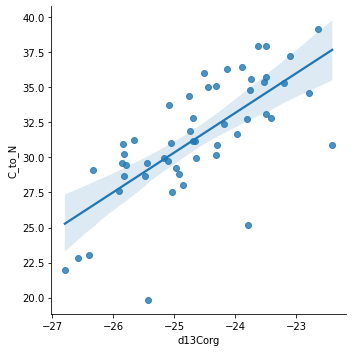

In [164]:
sb.lmplot(x=x_var, y=y_var, data=fit_df, fit_reg=True);

In [165]:
# Fit a linear model to the data
lm = ols(f'{y_var}~{x_var}', data=fit_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 C_to_N   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     51.82
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           2.94e-09
Time:                        17:29:36   Log-Likelihood:                -129.08
No. Observations:                  52   AIC:                             262.2
Df Residuals:                      50   BIC:                             266.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.0083      9.674     10.441      0.000      81.577     120.439
d13Corg        2.8269      0.393      7.199      0.000       2.038       3.616
==============================================================================
Omnibus:                       15.046   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.359
Skew:                          -1.142   Prob(JB):                     0.000170
Kurtosis:                       4.671   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
# Run ANOVA
anova_lm(lm, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
d13Corg,1.0,452.015665,452.015665,51.81873,2.936188e-09
Residual,50.0,436.150850,8.723017,NaN,NaN


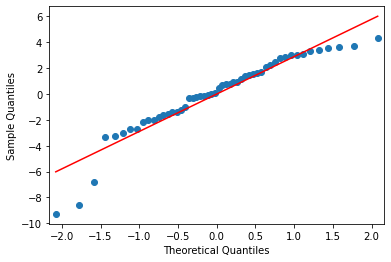

In [167]:
# Check assumptions for ANOVA:
# QQ plot
qqplot(lm.resid, line='s');
# If residuals are normally distributed, they should lie close to line (small deviations at top and bottom are ok)

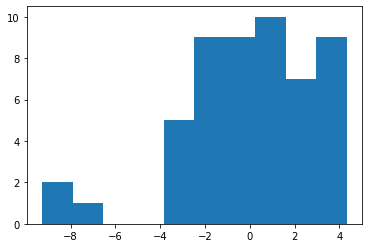

In [168]:
# Histogram of residuals
plt.figure()
plt.hist(lm.resid);

In [169]:
# Shapiro-Wilk test (returns probability of getting this distribution of residuals under the null hypothesis that it's normal)
shapiro(lm.resid)

ShapiroResult(statistic=0.9133486747741699, pvalue=0.0010731007205322385)

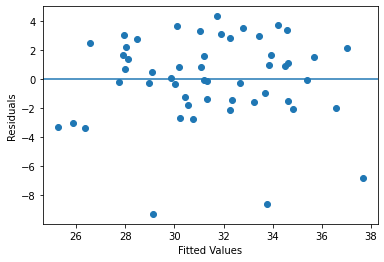

In [170]:
# Plot residuals vs fitted values
plt.figure()
plt.scatter(lm.fittedvalues,lm.resid) 
plt.axhline(y=0) 
plt.xlabel('Fitted Values') 
plt.ylabel('Residuals');
# If the relationship is indeed linear, there should not be systematic deviations from the line and the vertical variance should be ~ the same.

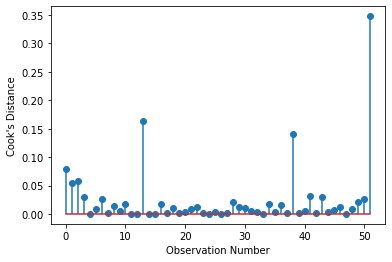

In [171]:
#Cook's distance 
plt.figure() 
cooks=lm.get_influence().cooks_distance[0] 
plt.stem(range(len(cooks)),cooks) 
plt.xlabel('Observation Number') 
plt.ylabel("Cook's Distance");
# Check to see if any points have a significant influence over the others (Cook's distance ≥ 0.5)

In [172]:
# Permutation test (no formal assumptions, but still check Cook's distance)
n_reps = 10000

x_list = list(fit_df[x_var])
y_list = list(fit_df[y_var])

actual_slope = linregress(x_list, y_list).slope # Should be the same as lm.params[x_var]

simulated_slopes = []

for i in range(n_reps):
    # Shuffle the y list
    random.shuffle(y_list)
    
    # Calculate the slope using the shuffled data and store it
    simulated_slopes.append(linregress(x_list, y_list).slope)
    
perm_p_value = len([s for s in simulated_slopes if s >= actual_slope])/n_reps

print(f'p-value from permutation test = {perm_p_value}')

p-value from permutation test = 0.0


In [173]:
perm_plot = go.Figure()
perm_plot.add_trace(go.Histogram(x=simulated_slopes))
perm_plot.add_vline(x=actual_slope)
perm_plot.update_layout(xaxis_title='Simulated regression slopes',
                        yaxis_title='Frequency')
perm_plot.show()